In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from PIL import Image


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Contracting Path
        self.enc1 = self.contracting_block(3, 64)
        self.enc2 = self.contracting_block(64, 128)
        self.enc3 = self.contracting_block(128, 256)
        self.enc4 = self.contracting_block(256, 512)
        # Bottleneck
        self.bottleneck = self.contracting_block(512, 1024)
        # Expanding Path
        self.upconv4 = self.expanding_block(1024, 512)
        self.upconv3 = self.expanding_block(512, 256)
        self.upconv2 = self.expanding_block(256, 128)
        self.upconv1 = self.expanding_block(128, 64)
        # Final layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        return block

    def expanding_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        return block

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        # Expanding Path
        dec4 = self.upconv4(bottleneck)
        dec3 = self.upconv3(dec4 + enc4)
        dec2 = self.upconv2(dec3 + enc3)
        dec1 = self.upconv1(dec2 + enc2)
        # Final layer
        return torch.sigmoid(self.final(dec1 + enc1))


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Using a pre-trained model as the base network
        self.cnn = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        # Modify the last layer
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)

    def forward_once(self, x):
        output = self.cnn(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim=512, num_classes=23):
        super(EmbeddingClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [2]:
import torch

# Load the U-Net segmentation model
unet_model = UNet()
unet_model.load_state_dict(torch.load("unet.pt", map_location="cpu", weights_only=True))
unet_model.eval()

# Load the classification model
model = SiameseNetwork()
model.load_state_dict(
    torch.load("01-balance/siamese-12.pt", map_location="cpu", weights_only=True)
)
model.eval()


classifier = EmbeddingClassifier()
classifier.load_state_dict(
    torch.load("classifier.pt", map_location="cpu", weights_only=True)
)
classifier.eval()

# Move models to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model.to(device)
model.to(device)
classifier.to(device)

EmbeddingClassifier(
  (fc): Linear(in_features=512, out_features=23, bias=True)
)

In [3]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


# Function to transform the image
def transform_image(image):
    transform = transforms.Compose(
        [
            transforms.Resize(
                (224, 224)
            ),  # Ensure the image size matches the model input size
            transforms.ToTensor(),
        ]
    )
    return transform(image)


# Define the root directory for fish images
root_dir = "fish_image"

# Get a list of all subfolders
subfolders = [
    os.path.join(root_dir, subfolder)
    for subfolder in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, subfolder))
]

# Choose a random subfolder and a random image within that subfolder
random_subfolder = random.choice(subfolders)
images = os.listdir(random_subfolder)
random_image_name = random.choice(images)
random_image_path = os.path.join(random_subfolder, random_image_name)

# Load a sample image for testing
test_image_pil = Image.open(random_image_path).convert("RGB")
test_image = transform_image(test_image_pil).unsqueeze(
    0
)  # Apply the transform and add batch dimension

# Move the input image to the same device as the model
test_image = test_image.to(device)

Predicted Class: 21
Correct Class: 21
Predicted Class: 10
Correct Class: 10
Predicted Class: 11
Correct Class: 11
Predicted Class: 5
Correct Class: 5
Predicted Class: 21
Correct Class: 21
Predicted Class: 4
Correct Class: 4
Predicted Class: 11
Correct Class: 11
Predicted Class: 22
Correct Class: 22
Predicted Class: 15
Correct Class: 15
Predicted Class: 13
Correct Class: 13
Predicted Class: 16
Correct Class: 16
Predicted Class: 14
Correct Class: 14


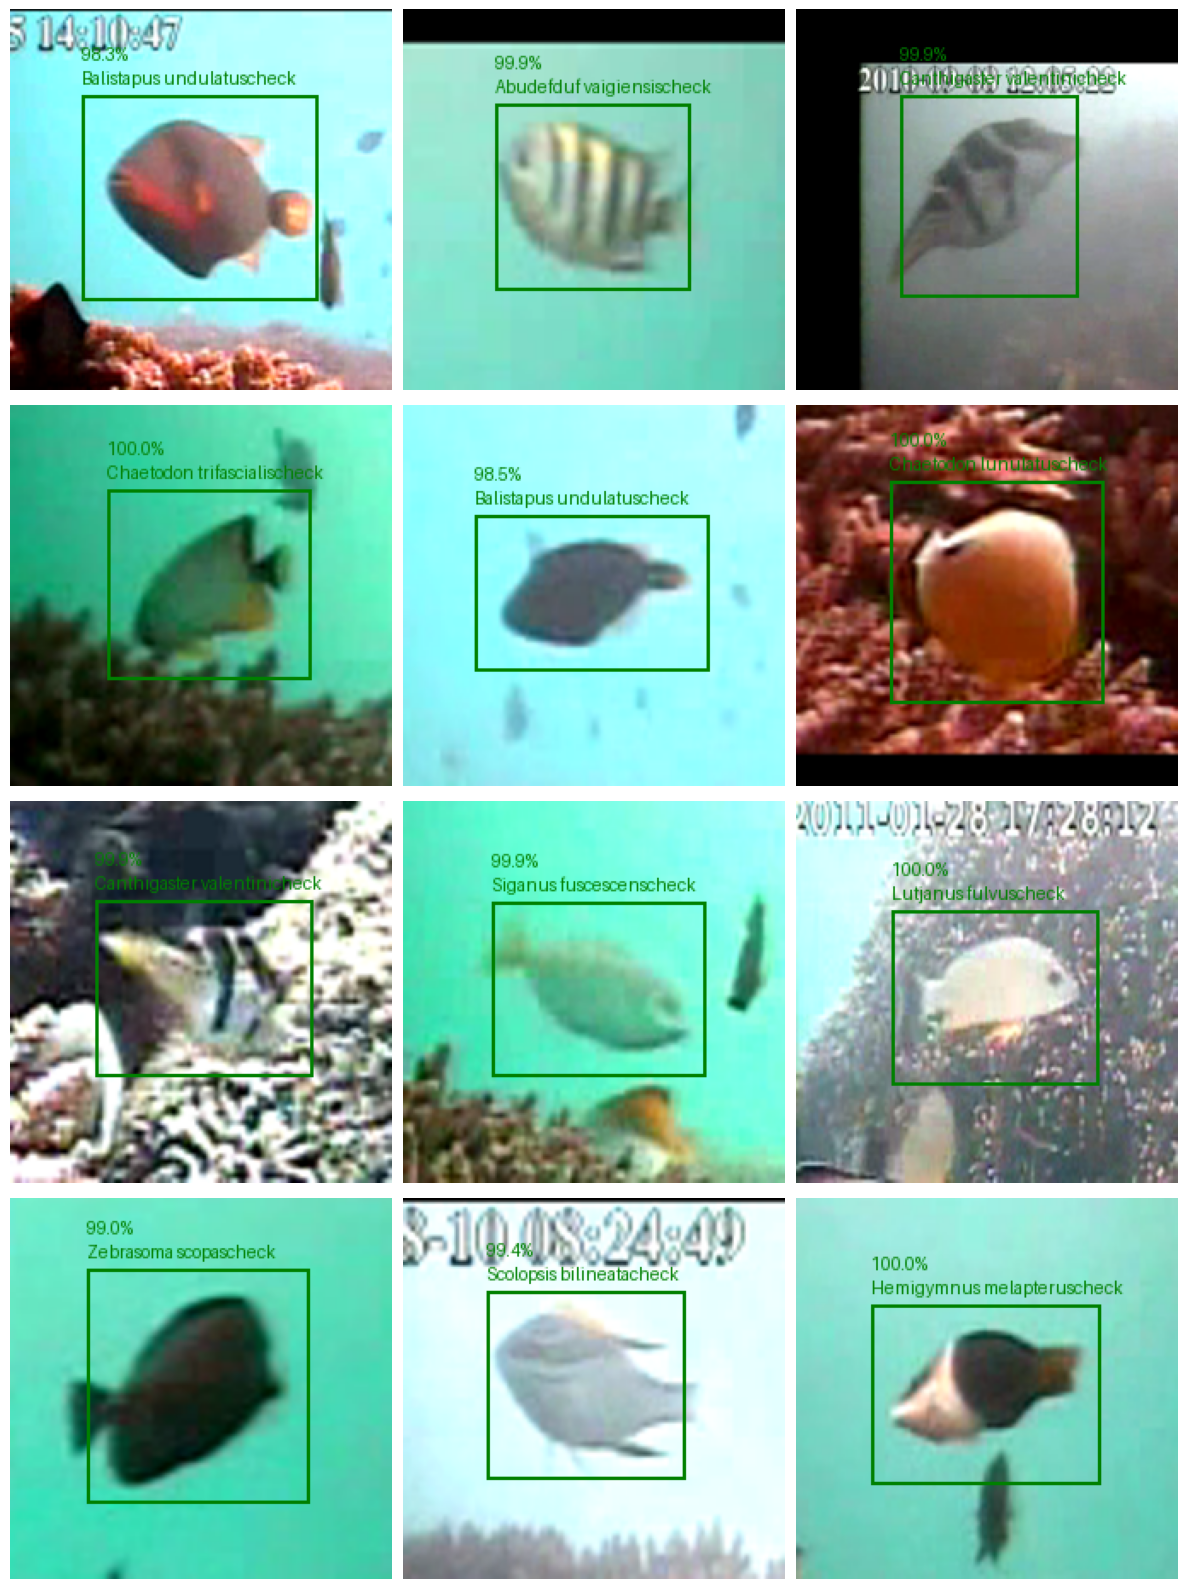

In [4]:
import os
import random
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Function to load and preprocess the image
def load_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


# Define the root directory for fish images
root_dir = "fish_image"

# Get a list of all subfolders
subfolders = [
    os.path.join(root_dir, subfolder)
    for subfolder in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, subfolder))
]
class_names = [
    "Dascyllus reticulatuscheck",
    "Plectroglyphidodon dickiicheck",
    "Chromis chrysuracheck",
    "Amphiprion clarkiicheck",
    "Chaetodon lunulatuscheck",
    "Chaetodon trifascialischeck",
    "Myripristis kunteecheck",
    "Acanthurus nigrofuscuscheck",
    "Hemigymnus fasciatuscheck",
    "Neoniphon sammaracheck",
    "Abudefduf vaigiensischeck",
    "Canthigaster valentinicheck",
    "Pomacentrus moluccensischeck",
    "Zebrasoma scopascheck",
    "Hemigymnus melapteruscheck",
    "Lutjanus fulvuscheck",
    "Scolopsis bilineatacheck",
    "Scaridaecheck",
    "Pempheris vanicolensischeck",
    "Zanclus cornutuscheck",
    "Neoglyphidodon nigrorischeck",
    "Balistapus undulatuscheck",
    "Siganus fuscescenscheck",
]

# Initialize the figure
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
axes = axes.flatten()

# Loop to display 12 random images
for ax in axes:
    random_subfolder = random.choice(subfolders)
    images = os.listdir(random_subfolder)
    random_image_name = random.choice(images)
    random_image_path = os.path.join(random_subfolder, random_image_name)

    # Load the image
    original_image = Image.open(random_image_path).convert("RGB")
    transformed_image = transform_image(original_image).unsqueeze(0).to(device)

    # Perform the segmentation
    unet_model.eval()
    with torch.no_grad():
        output = unet_model(transformed_image)
        mask = (output.squeeze().cpu().numpy() > 0.5).astype(
            "uint8"
        )  # Convert mask to binary

    # Resize the original image to match the mask size
    original_image = original_image.resize(
        (224, 224)
    )  # Resize to match the transformed size
    original_image_np = np.array(original_image)  # Convert to NumPy array

    image_tensor = load_image(random_image_path).to(device)

    subfolders = [
        os.path.join(root_dir, subfolder)
        for subfolder in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, subfolder))
    ]

    correct_class = int(random_image_path.split("/")[1].split("_")[1]) - 1

    model.eval()
    classifier.eval()
    img = Image.open(random_image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.forward_once(img)
        output = classifier(embedding)
        # probabilities = nn.functional.softmax(output, dim=1)
        probabilities = F.softmax(output, dim=1)  # Apply softmax to get probabilities
    predicted_class = torch.argmax(probabilities, 1).item()
    confidence_score = (
        probabilities[0, predicted_class].item() * 100
    )  # Convert to percentage
    class_name = class_names[predicted_class]

    print(f"Predicted Class: {predicted_class}")
    print(f"Correct Class: {correct_class}")

    predicted_class_name = class_names[predicted_class]

    # Find the bounding box coordinates
    y_indices, x_indices = np.where(mask == 1)
    if (
        y_indices.size > 0 and x_indices.size > 0
    ):  # Ensure there are non-zero values in the mask
        extra_padding = 15
        y_min, y_max = y_indices.min() - extra_padding, y_indices.max() + extra_padding
        x_min, x_max = x_indices.min() - extra_padding, x_indices.max() + extra_padding

        # Draw the bounding box on the original image
        original_image_with_box = Image.fromarray(original_image_np)
        draw = ImageDraw.Draw(original_image_with_box)

        # Draw rectangle with red outline
        draw.rectangle(
            [x_min, y_min, x_max, y_max],
            outline="red" if predicted_class != correct_class else "green",
            width=2,
        )

        # Set text and font
        text = f"{confidence_score:.1f}%\n{predicted_class_name}"
        font = ImageFont.load_default()  # Load the default font
        draw.text(
            (x_min, y_min - 30),
            text,
            fill="red" if predicted_class != correct_class else "green",
            font=font,
        )
    else:
        original_image_with_box = Image.fromarray(original_image_np)

    # Display the image
    ax.imshow(original_image_with_box)
    ax.axis("off")  # Turn off axis

# Adjust layout and show the grid
plt.tight_layout()
plt.show()